In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification-v2' dataset.
Path to dataset files: /kaggle/input/garbage-classification-v2


### Splitting the dataset into test, train and validation

In [5]:
def split_dataset(source_dir, target_dir, train_ratio=0.7, val_ratio=0.15):
    import os
    import shutil
    import random

    def split_exists(target_dir):
        required_folders = ["train", "val", "test"]
        for folder in required_folders:
            folder_path = os.path.join(target_dir, folder)
            if not os.path.exists(folder_path):
                return False
            if not any(
                os.listdir(os.path.join(folder_path, cls))
                for cls in os.listdir(folder_path)
                if os.path.isdir(os.path.join(folder_path, cls))
            ):
                return False
        return True

    if split_exists(target_dir):
        print(f"Split already exists at {target_dir} — skipping.")
        return

    print(f"Splitting dataset from {source_dir} → {target_dir}")

    classes = [d for d in os.listdir(source_dir)
               if os.path.isdir(os.path.join(source_dir, d))]

    for cls in classes:
        print(f"Processing class: {cls}")
        class_source = os.path.join(source_dir, cls)
        images = os.listdir(class_source)
        random.shuffle(images)

        n = len(images)
        train_end = int(n * train_ratio)
        val_end = train_end + int(n * val_ratio)

        train_imgs = images[:train_end]
        val_imgs = images[train_end:val_end]
        test_imgs = images[val_end:]

        for split in ["train", "val", "test"]:
            os.makedirs(os.path.join(target_dir, split, cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(
                os.path.join(class_source, img),
                os.path.join(target_dir, "train", cls)
            )
        for img in val_imgs:
            shutil.copy(
                os.path.join(class_source, img),
                os.path.join(target_dir, "val", cls)
            )
        for img in test_imgs:
            shutil.copy(
                os.path.join(class_source, img),
                os.path.join(target_dir, "test", cls)
            )

    print("Split complete!")


In [6]:
source_dir = path,
target_dir = "./garbage-dataset-split"


split_dataset(
    source_dir = path,
    target_dir = "./garbage-dataset-split"
)


Splitting dataset from /kaggle/input/garbage-classification-v2 → ./garbage-dataset-split
Processing class: metal
Processing class: glass
Processing class: biological
Processing class: paper
Processing class: battery
Processing class: trash
Processing class: cardboard
Processing class: shoes
Processing class: clothes
Processing class: plastic
Split complete!


In [7]:
import os
print(os.listdir(f'{path}'))

['metal', 'glass', 'biological', 'paper', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic']


In [11]:
from tensorflow.keras.preprocessing.image import load_img

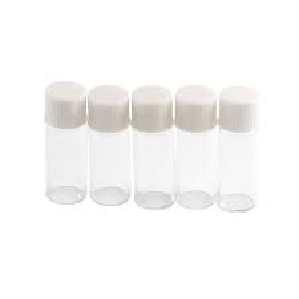

In [12]:
sample_image = os.path.join(
    target_dir,
    'train',
    'glass',
    os.listdir(f"{target_dir}/train/glass")[0]  # first file in the folder
)

img = load_img(sample_image, target_size=(299, 299))
img


In [13]:
x = np.array(img)
x.shape

(299, 299, 3)

In [14]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3),
    )

    base_model.trainable = False

######################################################
    inputs = keras.Input(shape=(input_size, input_size, 3))

    base = base_model(inputs, training=False)

    pooling = keras.layers.GlobalAveragePooling2D()
    vectors = pooling(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)        # droprate eindicates how much of the inner layer we freeze

    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)

    ######################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
        )

    return model

In [16]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range= 0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_ds = train_gen.flow_from_directory('./garbage-dataset-split/train',
                              target_size =(299, 299),
                              batch_size =32
                              )

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('./garbage-dataset-split/val',
                              target_size =(299, 299),
                              batch_size =32,
                              shuffle=False
                              )

Found 14142 images belonging to 10 classes.
Found 3027 images belonging to 10 classes.


In [17]:
checkpoint = keras.callbacks.ModelCheckpoint('xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                                )

In [18]:
learning_rate = 0.001
size = 100
droprate = 0.5
input_size = 299

model = make_model(
                learning_rate=learning_rate,
                input_size=input_size,
                size_inner=size,
                droprate=droprate,
)

history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                    callbacks=[checkpoint])
scores[droprate] = history.history

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.7589 - loss: 0.7798

442/442 ━━━━━━━━━━━━━━━━━━━━ 493s 1s/step - accuracy: 0.7591 - loss: 0.7792 - val_accuracy: 0.9131 - val_loss: 0.2714
Epoch 2/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.8975 - loss: 0.3383

442/442 ━━━━━━━━━━━━━━━━━━━━ 377s 852ms/step - accuracy: 0.8975 - loss: 0.3383 - val_accuracy: 0.9171 - val_loss: 0.2396
Epoch 3/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 0.9082 - loss: 0.2856

442/442 ━━━━━━━━━━━━━━━━━━━━ 376s 850ms/step - accuracy: 0.9082 - loss: 0.2856 - val_accuracy: 0.9177 - val_loss: 0.2407
Epoch 4/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.9163 - loss: 0.2557

442/442 ━━━━━━━━━━━━━━━━━━━━ 378s 854ms/step - accuracy: 0.9163 - loss: 0.2557 - val_accuracy: 0.9243 - val_loss: 0.2172
Epoch 5/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.9207 - loss: 0.2389

442/442 ━━━━━━━━━━━━━━━━━━━━ 378s 854ms/step - accuracy: 0.9207 - loss: 0.2389 - val_accuracy: 0.9277 - val_loss: 0.2188
Epoch 6/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 374s 845ms/step - accuracy: 0.9248 - loss: 0.2214 - val_accuracy: 0.9250 - val_loss: 0.2218
Epoch 7/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9273 - loss: 0.2087

442/442 ━━━━━━━━━━━━━━━━━━━━ 381s 860ms/step - accuracy: 0.9273 - loss: 0.2087 - val_accuracy: 0.9290 - val_loss: 0.2079
Epoch 8/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9350 - loss: 0.1957

442/442 ━━━━━━━━━━━━━━━━━━━━ 394s 892ms/step - accuracy: 0.9350 - loss: 0.1957 - val_accuracy: 0.9339 - val_loss: 0.1942
Epoch 9/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.9361 - loss: 0.1888

442/442 ━━━━━━━━━━━━━━━━━━━━ 385s 870ms/step - accuracy: 0.9361 - loss: 0.1888 - val_accuracy: 0.9362 - val_loss: 0.1962
Epoch 10/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.9396 - loss: 0.1897

442/442 ━━━━━━━━━━━━━━━━━━━━ 385s 872ms/step - accuracy: 0.9396 - loss: 0.1897 - val_accuracy: 0.9389 - val_loss: 0.1922
Epoch 11/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 386s 873ms/step - accuracy: 0.9407 - loss: 0.1724 - val_accuracy: 0.9386 - val_loss: 0.1983
Epoch 12/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9393 - loss: 0.1789

442/442 ━━━━━━━━━━━━━━━━━━━━ 382s 862ms/step - accuracy: 0.9393 - loss: 0.1789 - val_accuracy: 0.9432 - val_loss: 0.1941
Epoch 13/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 382s 865ms/step - accuracy: 0.9446 - loss: 0.1592 - val_accuracy: 0.9402 - val_loss: 0.1925
Epoch 14/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 383s 866ms/step - accuracy: 0.9454 - loss: 0.1643 - val_accuracy: 0.9405 - val_loss: 0.1970
Epoch 15/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 381s 862ms/step - accuracy: 0.9489 - loss: 0.1469 - val_accuracy: 0.9356 - val_loss: 0.2005
Epoch 16/50
442/442 ━━━━━━━━━━━━━━━━━━━━ 383s 866ms/step - accuracy: 0.9451 - loss: 0.1577 - val_accuracy: 0.9419 - val_loss: 0.1926
Epoch 17/50
189/442 ━━━━━━━━━━━━━━━━━━━━ 3:23 804ms/step - accuracy: 0.9528 - loss: 0.1388

KeyboardInterrupt: 

### Loading the model

In [19]:
# load test data
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory('./garbage-dataset-split/test',
                              target_size =(299, 299),
                              batch_size =32,
                              shuffle=False
                              )

Found 3043 images belonging to 10 classes.


In [20]:
model = keras.models.load_model('xception_v4_12_0.943.h5')

In [21]:
model.evaluate(test_ds)

96/96 ━━━━━━━━━━━━━━━━━━━━ 58s 475ms/step - accuracy: 0.9367 - loss: 0.1997


[0.20292015373706818, 0.9362471103668213]

In [26]:
path = './garbage-dataset-split/test/clothes/clothes_1049.jpg'


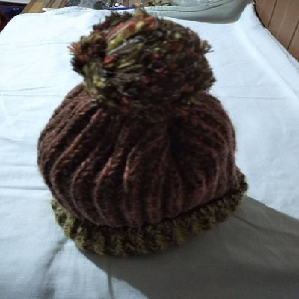

In [29]:
img = load_img(path, target_size=(299, 299))
img

In [30]:
x = np.array(img)
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [31]:
X = preprocess_input(X)

In [32]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


In [33]:
classes = [
    'battery',
    'biological',
    'cardboard',
    'clothes',
    'glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash'
  ]

In [34]:
dict(zip(classes, pred[0]))

{'battery': np.float32(-13.225006),
 'biological': np.float32(6.258689),
 'cardboard': np.float32(-5.080427),
 'clothes': np.float32(8.567228),
 'glass': np.float32(-1.7091714),
 'metal': np.float32(-4.7778788),
 'paper': np.float32(0.8639797),
 'plastic': np.float32(-3.9040344),
 'shoes': np.float32(-0.002963759),
 'trash': np.float32(-3.243034)}

In [36]:
model.export("xception_v4_final")

Saved artifact at 'xception_v4_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133943926937680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926939984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926941136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926936528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926935760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926942096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13394

In [37]:
from google.colab import userdata
from huggingface_hub import HfApi

# Export model
model.export("xception_v4_final")

# Get token from Colab secrets (won't be visible in notebook)
hf_token = userdata.get('HF_TOKEN')

# Upload to HuggingFace
api = HfApi()
api.upload_folder(
    folder_path="xception_v4_final",
    repo_id="Folakunmi21/garbage-classifier",
    path_in_repo="xception_v4_final",
    token=hf_token
)

print("Uploaded to HuggingFace!")

Saved artifact at 'xception_v4_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133943926937680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926939984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926941136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926936528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926940944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926935760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133943926942096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13394

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ables.data-00000-of-00001:  14%|#3        | 23.4MB /  169MB            

  ...n_v4_final/fingerprint.pb:   1%|1         |  1.00B /  78.0B            

  ...n_v4_final/saved_model.pb:   1%|1         | 20.9kB / 1.49MB            

Uploaded to HuggingFace!
